In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
DATASET_DIR = "./KTH_TIPS"  
IMG_SIZE = (128, 128)

In [3]:
image_paths = []
labels = []

for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    for fname in sorted(os.listdir(class_path)):
        if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")):
            image_paths.append(os.path.join(class_path, fname))
            labels.append(class_name)

print("Всего изображений:", len(image_paths))
print("Пример класса:", labels[0] if len(labels) else "нет данных")

Всего изображений: 810
Пример класса: aluminium_foil


In [4]:
images = []
good_labels = []

for path, lab in zip(image_paths, labels):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    images.append(img)
    good_labels.append(lab)

images = np.array(images)   
good_labels = np.array(good_labels)
print("images:", images.shape)
print("labels:", good_labels.shape)

images: (810, 128, 128)
labels: (810,)


In [5]:
le = LabelEncoder()
y = le.fit_transform(good_labels)

print("Классы:", list(le.classes_))
print("y:", y[:10])

Классы: [np.str_('aluminium_foil'), np.str_('brown_bread'), np.str_('corduroy'), np.str_('cotton'), np.str_('cracker'), np.str_('linen'), np.str_('orange_peel'), np.str_('sandpaper'), np.str_('sponge'), np.str_('styrofoam')]
y: [0 0 0 0 0 0 0 0 0 0]


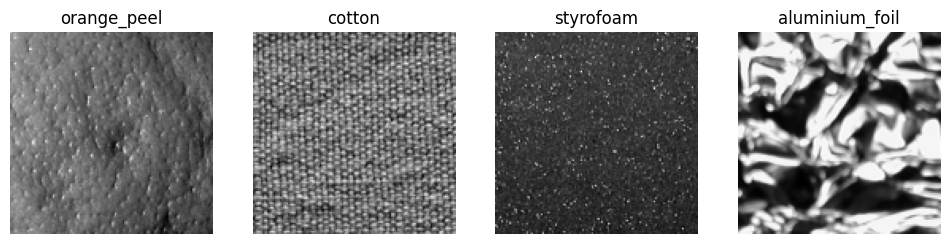

In [6]:
idxs = np.random.choice(len(images), size=min(4, len(images)), replace=False)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(idxs, 1):
    plt.subplot(1, len(idxs), i)
    plt.imshow(images[idx], cmap="gray")
    plt.title(le.classes_[y[idx]])
    plt.axis("off")
plt.show()

In [7]:
# 1. Гистограмма
def extract_hist_features(gray_image, bins=256):
    hist = cv2.calcHist([gray_image], [0], None, [bins], [0, 256]).flatten()
    hist = hist / (hist.sum() + 1e-12)

    values = np.arange(bins)

    mean_val = np.sum(hist * values)
    var_val = np.sum(hist * (values - mean_val) ** 2)
    std_val = np.sqrt(var_val) + 1e-12
    skew_val = np.sum(hist * ((values - mean_val) / std_val) ** 3)
    kurt_val = np.sum(hist * ((values - mean_val) / std_val) ** 4) - 3.0

    nonzero = hist[hist > 0]
    ent_val = -np.sum(nonzero * np.log2(nonzero))

    cdf = np.cumsum(hist)
    q1 = int(np.argmax(cdf >= 0.25))
    q2 = int(np.argmax(cdf >= 0.50))
    q3 = int(np.argmax(cdf >= 0.75))

    nz_bins = np.where(hist > 0)[0]
    if len(nz_bins) > 0:
        min_bin = int(nz_bins[0])
        max_bin = int(nz_bins[-1])
    else:
        min_bin, max_bin = 0, bins - 1

    return np.array([mean_val, std_val, skew_val, kurt_val, ent_val, q1, q2, q3, min_bin, max_bin], dtype=np.float32)

X_hist = np.array([extract_hist_features(img, bins=256) for img in images], dtype=np.float32)

print("X_hist shape:", X_hist.shape)
print("Пример X_hist[0]:", X_hist[0])

X_hist shape: (810, 10)
Пример X_hist[0]: [ 1.3510333e+02  8.2213943e+01 -1.0584804e-02 -1.5174555e+00
  7.4176421e+00  5.2000000e+01  1.3500000e+02  2.2200000e+02
  8.0000000e+00  2.5100000e+02]


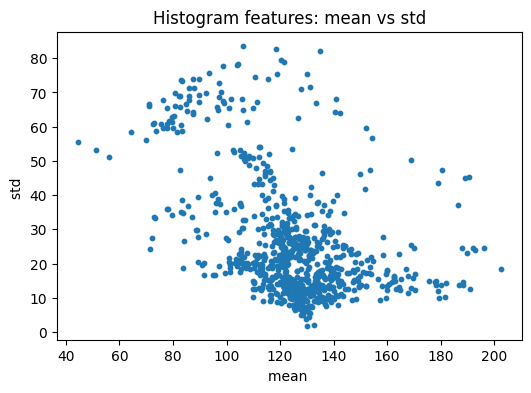

In [8]:
plt.figure(figsize=(6, 4))
plt.scatter(X_hist[:, 0], X_hist[:, 1], s=10)
plt.xlabel("mean ")
plt.ylabel("std ")
plt.title("Histogram features: mean vs std")
plt.show()

In [9]:
# 3. Laws
def extract_laws_features(gray_image, normalize=True):
    # Базовые 1D фильтры Laws
    L5 = np.array([1, 4, 6, 4, 1])
    E5 = np.array([-1, -2, 0, 2, 1])
    S5 = np.array([-1, 0, 2, 0, -1])
    W5 = np.array([-1, 2, 0, -2, 1])
    R5 = np.array([1, -4, 6, -4, 1])

    filters_1d = [L5, E5, S5, W5, R5]
    features = []

    for f1 in filters_1d:
        for f2 in filters_1d:
            kernel = np.outer(f1, f2)
            filtered = cv2.filter2D(gray_image.astype(np.float32), -1, kernel)
            energy = np.mean(filtered ** 2)
            features.append(energy)

    features = np.array(features, dtype=np.float32)
    # Нормализация
    if normalize and features.sum() > 0:
        features /= features.sum()

    return features

In [10]:

X_laws = np.array([extract_laws_features(img) for img in images], dtype=np.float32)

print("X_laws shape:", X_laws.shape)
print("Пример X_laws[0]:", X_laws[0])

X_laws shape: (810, 25)
Пример X_laws[0]: [9.9015898e-01 2.9913178e-03 3.6467632e-04 1.4430049e-04 2.6576611e-04
 4.6312842e-03 1.0852917e-04 1.8712853e-05 9.8666824e-06 1.8902187e-05
 5.4950034e-04 2.0184805e-05 4.7433296e-06 3.1839063e-06 6.7859992e-06
 2.1823194e-04 1.1247166e-05 3.1915915e-06 2.4295193e-06 5.9993254e-06
 4.0477945e-04 2.5394678e-05 7.5549656e-06 6.0502762e-06 1.8362936e-05]


In [11]:
# 3. GLM
from skimage.feature import graycomatrix, graycoprops

In [12]:
def extract_glcm_features(gray_image,
                          distances=(1,),
                          angles=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                          levels=32):

    img_q = (gray_image * (levels / 256)).astype(np.uint8)
    img_q = np.clip(img_q, 0, levels - 1)

    glcm = graycomatrix(img_q,
                        distances=distances,
                        angles=angles,
                        levels=levels,
                        symmetric=True,
                        normed=True)

    props = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation"]
    feats = []
    for p in props:
        feats.append(graycoprops(glcm, p).mean())

    return np.array(feats, dtype=np.float32)

In [13]:
X_glcm = np.array([extract_glcm_features(img) for img in images], dtype=np.float32)

print("X_glcm shape:", X_glcm.shape)
print("Пример X_glcm[0]:", X_glcm[0])

X_glcm shape: (810, 5)
Пример X_glcm[0]: [16.252691    2.5006127   0.46538556  0.157141    0.92377734]


In [14]:
# 4. Обучение классификаторов
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def train_and_evaluate(X, y, name):
    print(f"\n=== Признаки: {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    # Масштабирование
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    results = {}

    # KNN 
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_sc, y_train)
    y_pred = knn.predict(X_test_sc)
    acc = accuracy_score(y_test, y_pred)
    results["KNN"] = acc
    print(f"KNN accuracy: {acc:.3f}")

    # SVM 
    svm = SVC(kernel="rbf", random_state=42)
    svm.fit(X_train_sc, y_train)
    y_pred = svm.predict(X_test_sc)
    acc = accuracy_score(y_test, y_pred)
    results["SVM"] = acc
    print(f"SVM accuracy: {acc:.3f}")

    # Decision Tree 
    tree = DecisionTreeClassifier(max_depth=10, random_state=42)
    tree.fit(X_train, y_train) 
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results["DecisionTree"] = acc
    print(f"Decision Tree accuracy: {acc:.3f}")

    return results

In [15]:
results_hist = train_and_evaluate(X_hist, y, "Histogram")
results_laws = train_and_evaluate(X_laws, y, "Laws")
results_glcm = train_and_evaluate(X_glcm, y, "GLCM")


=== Признаки: Histogram ===
KNN accuracy: 0.837
SVM accuracy: 0.837
Decision Tree accuracy: 0.833

=== Признаки: Laws ===
KNN accuracy: 0.813
SVM accuracy: 0.576
Decision Tree accuracy: 0.729

=== Признаки: GLCM ===
KNN accuracy: 0.621
SVM accuracy: 0.552
Decision Tree accuracy: 0.493


In [16]:
# 5. Сегментация
def fit_knn_for_features(X, y, k=3):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_sc, y_train)

    return model, scaler

In [17]:
def segment_image_by_model(image_path, model, scaler,
                           feature_type="hist",
                           window_size=16,
                           step=8):
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path}")

    h, w = img.shape
    seg_map = np.zeros((h, w), dtype=np.int32)

    for y0 in range(0, h - window_size + 1, step):
        for x0 in range(0, w - window_size + 1, step):
            patch = img[y0:y0 + window_size, x0:x0 + window_size]

            # признаки
            if feature_type == "hist":
                feat = extract_hist_features(patch).reshape(1, -1)
            elif feature_type == "laws":
                feat = extract_laws_features(patch).reshape(1, -1)
            elif feature_type == "glcm":
                feat = extract_glcm_features(patch).reshape(1, -1)
            else:
                raise ValueError("feature_type должен быть: 'hist', 'laws' или 'glcm'")

            feat_sc = scaler.transform(feat)
            pred = model.predict(feat_sc)[0]
            seg_map[y0:y0 + window_size, x0:x0 + window_size] = pred

    return img, seg_map

In [18]:
knn_hist, scaler_hist = fit_knn_for_features(X_hist, y, k=3)
knn_laws, scaler_laws = fit_knn_for_features(X_laws, y, k=3)
knn_glcm, scaler_glcm = fit_knn_for_features(X_glcm, y, k=3)

In [19]:
TEST_IMAGE_PATH = "images.jpg"

img, seg_hist = segment_image_by_model(
    TEST_IMAGE_PATH, knn_hist, scaler_hist,
    feature_type="hist", window_size=16, step=8
)

_, seg_laws = segment_image_by_model(
    TEST_IMAGE_PATH, knn_laws, scaler_laws,
    feature_type="laws", window_size=16, step=8
)

_, seg_glcm = segment_image_by_model(
    TEST_IMAGE_PATH, knn_glcm, scaler_glcm,
    feature_type="glcm", window_size=16, step=8
)

print("Сегментация выполнена тремя методами.")

Сегментация выполнена тремя методами.


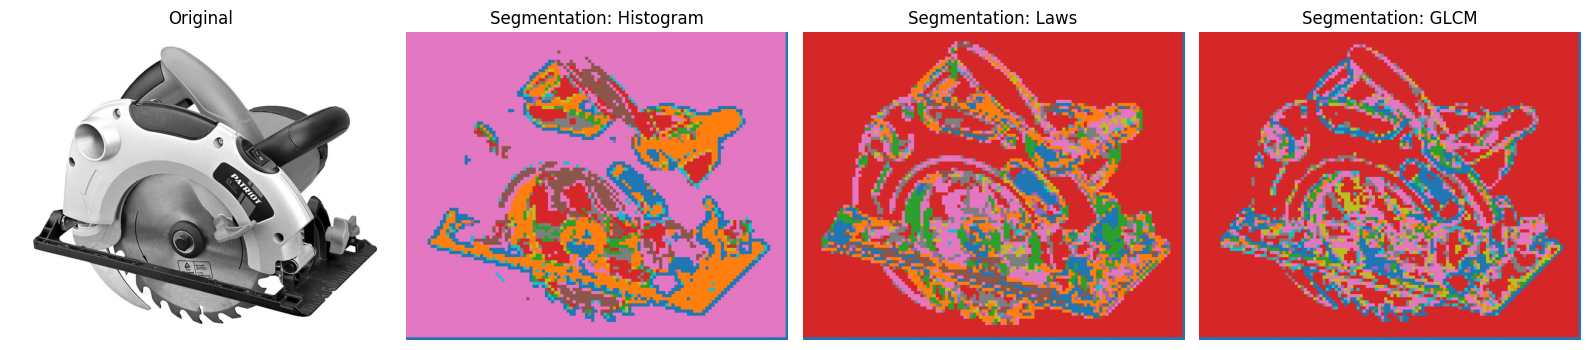

In [20]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(seg_hist, cmap="tab10")
plt.title("Segmentation: Histogram")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(seg_laws, cmap="tab10")
plt.title("Segmentation: Laws")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(seg_glcm, cmap="tab10")
plt.title("Segmentation: GLCM")
plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
# 7. Ручная разметка
def create_manual_mask(image_gray):
    # Автоматический порог (Otsu)
    _, mask = cv2.threshold(
        image_gray, 0, 1,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

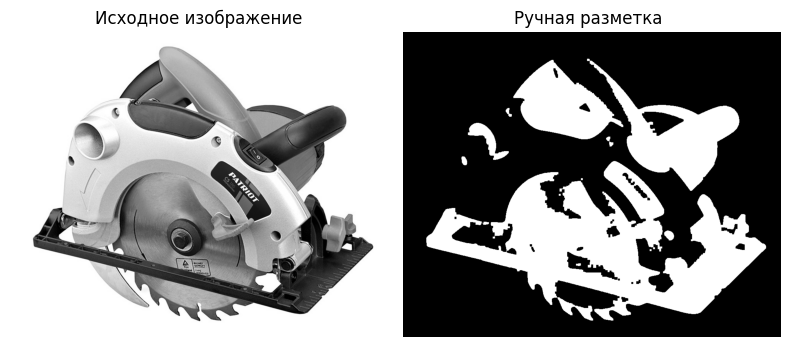

In [22]:
img_gray = cv2.imread(TEST_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

manual_mask = create_manual_mask(img_gray)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(manual_mask, cmap="gray")
plt.title("Ручная разметка ")
plt.axis("off")

plt.tight_layout()
plt.show()

In [23]:
def segmentation_to_binary(seg_map, manual_mask):
    classes = np.unique(seg_map)
    best_class = None
    best_overlap = 0

    for c in classes:
        overlap = np.sum((seg_map == c) & (manual_mask == 1))
        if overlap > best_overlap:
            best_overlap = overlap
            best_class = c

    binary_seg = (seg_map == best_class).astype(np.uint8)
    return binary_seg

In [24]:
from sklearn.metrics import accuracy_score, jaccard_score

def evaluate_segmentation(manual_mask, pred_mask, name):
    acc = accuracy_score(manual_mask.flatten(), pred_mask.flatten())
    iou = jaccard_score(manual_mask.flatten(), pred_mask.flatten())

    print(f"{name}:")
    print(f"  Accuracy = {acc:.3f}")
    print(f"  IoU      = {iou:.3f}")
    print()

In [25]:
# Histogram
bin_hist = segmentation_to_binary(seg_hist, manual_mask)
evaluate_segmentation(manual_mask, bin_hist, "Histogram")

# Laws
bin_laws = segmentation_to_binary(seg_laws, manual_mask)
evaluate_segmentation(manual_mask, bin_laws, "Laws")

# GLCM
bin_glcm = segmentation_to_binary(seg_glcm, manual_mask)
evaluate_segmentation(manual_mask, bin_glcm, "GLCM")

Histogram:
  Accuracy = 0.809
  IoU      = 0.357

Laws:
  Accuracy = 0.738
  IoU      = 0.190

GLCM:
  Accuracy = 0.197
  IoU      = 0.090



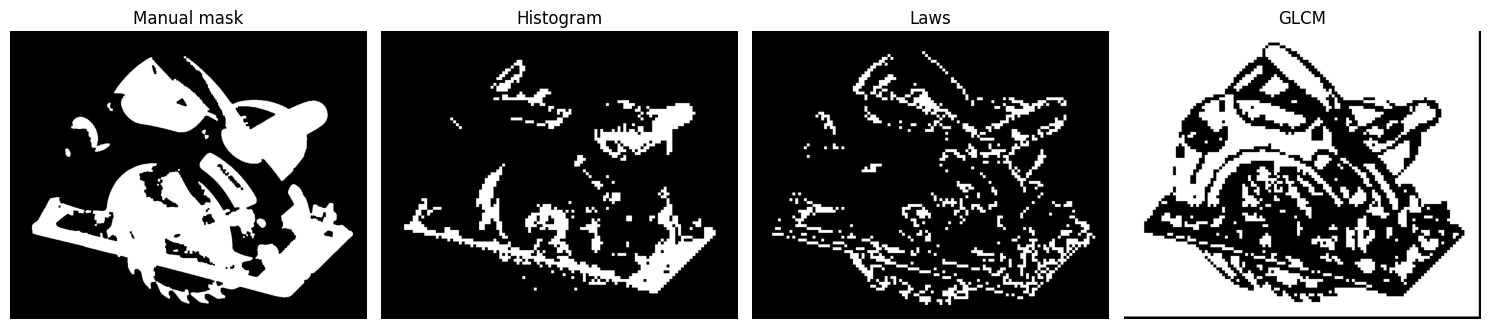

In [26]:

plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.imshow(manual_mask, cmap="gray")
plt.title("Manual mask")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(bin_hist, cmap="gray")
plt.title("Histogram")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(bin_laws, cmap="gray")
plt.title("Laws")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(bin_glcm, cmap="gray")
plt.title("GLCM")
plt.axis("off")

plt.tight_layout()
plt.show()